Predictors for:

dino CM proportion
dino CM diversity (among other dinos)
CM proportion 
CM diversity (among all other ASVs?)

with env features, with pigment features?
with 18Sv4 and v9, can average results

**Objective: ranking features by how much they reduce sum of squared residuals on base estimators of best performing bagging models.**


Results:

Scatterplots and graphs tell the story: most of this data is zeroes. Can't tell anything meaningful with it, and it obscures patterns which could be found elsewhere. Start focusing on the data you actually want (drop the zeroes) and compare "diatom heavy" vs "dino CM heavy" samples: what's different, what's the same?

Inevitable result (?) of only considering a few hundred ASVs out of 34k+ in 18Sv4, etc. Would be more useful to do co-occurrence, community clustering, or other analyses with all available ASVs and then just extract the networks of known mixotrophs (the subgraphs centered on those ASVs). Even then, number of 0s may mean poor pairwise associations... could add counts for CMs together? 

Results:
Seeing how things turn out with the non-outlier samples brought back in: ust the same as adding a lot more zeroes, but doesn't really tell us anything.

Even though the whole point of this was to find out which variables are associated with a rise in CM proportion, sheer amount of zeroes (with very diverse environmental conditions) means that (for example) bagging can very easily lower MSE with trivial splits, and linear methods also have trouble (even with nonlinear methods, harder to get significant coefficients. PCA/RDA would find some vectors but nothing more interesting.

So instead we found a "comparable" group in the diatoms - are they really comparable metabolically? And with this group we confirm what should have been obvious before: there's no particular link of environmental variables to CM proportion except maybe season.

But now I have another question: are we even going to get a significant association of CM proportion with any of the environmental variables? Flashweave uses Aitchison/CLR for normalization. And "proportion" could just as easily represent a reduction in biomass overall... so maybe underlying community patterns don't really change, it's just that CMs are accompanied by fewer producers...
- Flashweave should be able to adjust pairwise mutual information when "probability" of CM achieving a particular count or log ratio is 0... so keep the zeroes, while marking the outliers: might be a useful metavariable
plan is: get the "neighbors" (highest association) of each (dino, otherwise) CM and of the metavariables. Then can add up those into a single category and track year/month flows, etc. So question becomes, which samples are dominated by an outlier proportion of "neighbors/direct associates of CMs", and do those have a notably different distribution of seasons (categorical) compared to (again?) diatoms (or neighbors of the same?)
- in that case we could well ask: are the diatom neighbors so different from CM neighbors to start with?

Tables which Flashweave needs: all-asv table (raw), and env_metadata with new variable.

**What this notebook achieves**: May want to minimize zeroes by filtering rows and columns: dropping samples as required, and establishing a criterion for ASV inclusion **or consolidation.**

From Chaffron: "As log transformation cannot be applied to zero values, we added beforehand a pseudo count of one to all elements of the matrix. Last, to reduce the high dimensionality of our data, which may be the source of false-positive predicted associations, we filtered each abundance matrix using a top-quartile filtering approach. For each sample, the upper quartile (Q3) of its nonzero abundance values was computed. An OTU was retained when its observed abundance was higher than \[per-sample\] Q3 in at least five samples."

what I'll do to filter rows:
1) MLD only? I wouldn't do this except that the 18Sv4 and v9 have such seemingly different numbers of outliers for dinos vs diatoms. difference seemingly attibutable only to primer/amplicon choice.

what I'll do to filter columns: 
1) consolidate ASVs which refer to the same species. Have to match on the *species level*.
2) drop all ASVs or ASV "clusters" which don't pass the Q3 filter.

What does ETL mean? https://en.wikipedia.org/wiki/Extract,_transform,_load

### Reading and preprocessing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Import the following files: 

env_features with sample metadata.

asv_freqs tables describing species frequencies (proportions). will use these to develop per-sample features relating CM and diatom frequencies.

asv_taxo_mft tables describing species taxonomy, most specific name, and MFT (yes/no). Taxonomy is according to naive bayes classification on pr2. up to 9 components in a determined order, separated by ";"

raw_asv_ tables: raw counts without any pre-processing, also include Spike counts. use these as main input to flashweave, since flashweave takes integer tables and transforms them to "centered log ratio" values.

In [2]:
asv_freqs_18Sv4 = pd.read_csv("01_out_asv_proportions_18Sv4.tsv", sep = "\t", index_col=0)
asv_freqs_18Sv9 = pd.read_csv("01_out_asv_proportions_18Sv9.tsv", sep = "\t", index_col=0)

In [3]:
env_features_18Sv4 = pd.read_csv("01_out_env_features_18Sv4.tsv", sep = "\t", index_col=0)
env_features_18Sv9 = pd.read_csv("01_out_env_features_18Sv9.tsv", sep = "\t", index_col=0)

In [4]:
#no longer recognizes missing values (such as empty strings) and replaces them with np.nan
asv_taxo_mft_18Sv4 = pd.read_csv("01_out_asv_taxo_mft_18Sv4.tsv", sep = "\t", index_col=0, na_filter=False)
asv_taxo_mft_18Sv9 = pd.read_csv("01_out_asv_taxo_mft_18Sv9.tsv", sep = "\t", index_col=0, na_filter=False)

In [5]:
raw_asv_counts_18Sv4 = pd.read_csv("01_out_raw_asv_counts_18Sv4.tsv", sep = "\t", index_col = 0)
raw_asv_counts_18Sv9 = pd.read_csv("01_out_raw_asv_counts_18Sv9.tsv", sep = "\t", index_col = 0)

In [6]:
env_features_18Sv4

,Cast_Type,Cardinal_Sta,Lat_Dec,Lon_Dec,Bottle_Depth,T_degC,Salnty,STheta,O2ml_L,PO4ug,...,NO3ug,NH3ug,ChlorA,Phaeop,RecInd,MLD_Sigma,year,month,season,Mins_since_0000
X201402_086.7_033.0_10,Prodo,False,33.88950,-118.49250,10.0,14.652000,33.495701,24.888700,5.661,0.48,...,1.80,0.51,1.461,0.427,3.0,24.152739,2014.0,2.0,winter,1161.0
X201402_086.7_033.0_22,Prodo,False,33.88950,-118.49250,22.0,14.619000,33.494900,24.895889,5.624,0.50,...,1.80,0.62,1.333,0.417,3.0,24.152739,2014.0,2.0,winter,1161.0
X201402_090.0_037.0_10,Ros,True,33.18017,-118.39332,10.0,15.544000,33.530701,24.721359,5.822,0.34,...,0.00,0.01,0.362,0.097,3.0,13.239982,2014.0,2.0,winter,122.0
X201402_090.0_037.0_30,Ros,True,33.18017,-118.39332,30.0,14.020000,33.443100,24.982420,5.748,0.48,...,1.40,0.02,1.489,0.426,3.0,13.239982,2014.0,2.0,winter,122.0
X201402_090.0_053.0_10,Ros,True,32.65117,-119.48417,10.0,14.460000,33.290100,24.770920,5.897,0.37,...,0.10,0.05,0.466,0.122,3.0,21.755340,2014.0,2.0,winter,600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X202010_093.3_050.0_10,NaN,False,32.17972,-118.89242,10.0,20.429001,33.686600,23.649481,5.350,0.14,...,0.18,NaN,0.263,0.103,NaN,10.429259,2020.0,10.0,fall,1102.0
X202010_093.3_050.0_30,NaN,False,32.17972,-118.89242,29.0,15.711000,33.455700,24.627911,5.594,0.36,...,0.93,NaN,1.019,0.542,NaN,10.429259,2020.0,10.0,fall,1102.0
X202010_093.3_090.0_10,Ross,False,30.84673,-121.59022,10.0,19.943001,33.251400,23.445560,5.388,NaN,...,NaN,NaN,NaN,NaN,NaN,14.173782,2020.0,10.0,fall,1163.0
X202010_093.3_090.0_75,Ross,False,30.84673,-121.59022,75.0,13.073000,32.908600,24.763290,6.186,NaN,...,NaN,NaN,NaN,NaN,NaN,14.173782,2020.0,10.0,fall,1163.0


In [7]:
#is the number of samples equal in all tables which contain them
(raw_asv_counts_18Sv4.columns == env_features_18Sv4.index).all(),\
(raw_asv_counts_18Sv9.columns == env_features_18Sv9.index).all(),\
(raw_asv_counts_18Sv4.columns == asv_freqs_18Sv4.columns).all(),\
(raw_asv_counts_18Sv9.columns == asv_freqs_18Sv9.columns).all()

(True, True, True, True)

### Creating 1 more sample metavariable: "is this a CM-dominated or diatom-dominated sample"?

X-dominated sample: sample in which there is an outlier proportion of diatom OR CM (all CMs), and in which proportion of X exceeds proportion of Y.

Use asv_taxo_mft to get lists of CM and lists of diatom ASVs. Then, add their frequencies within each sample.

In [8]:
#some of the MFTs are NaN... replace with ""?
CM_asvs_18Sv4 = asv_taxo_mft_18Sv4.loc[ asv_taxo_mft_18Sv4["MFT"].str.contains("CM") ].index
CM_asvs_18Sv9 = asv_taxo_mft_18Sv9.loc[ asv_taxo_mft_18Sv9["MFT"].str.contains("CM") ].index

diatom_asvs_18Sv4 = asv_taxo_mft_18Sv4.loc[ asv_taxo_mft_18Sv4['Taxon'].str.contains("Bacillariophyceae") ].index
diatom_asvs_18Sv9 = asv_taxo_mft_18Sv9.loc[ asv_taxo_mft_18Sv9['Taxon'].str.contains("Bacillariophyceae") ].index

CM_asvs_18Sv4.size, CM_asvs_18Sv9.size, diatom_asvs_18Sv4.size, diatom_asvs_18Sv9.size

(583, 630, 263, 268)

In [9]:
CM_asv_freqs_18Sv4 = asv_freqs_18Sv4.loc[CM_asvs_18Sv4].apply(sum, axis = 0)
CM_asv_freqs_18Sv9 = asv_freqs_18Sv9.loc[CM_asvs_18Sv9].apply(sum, axis = 0)

diatom_asv_freqs_18Sv4 = asv_freqs_18Sv4.loc[diatom_asvs_18Sv4].apply(sum, axis = 0)
diatom_asv_freqs_18Sv9 = asv_freqs_18Sv9.loc[diatom_asvs_18Sv9].apply(sum, axis = 0)

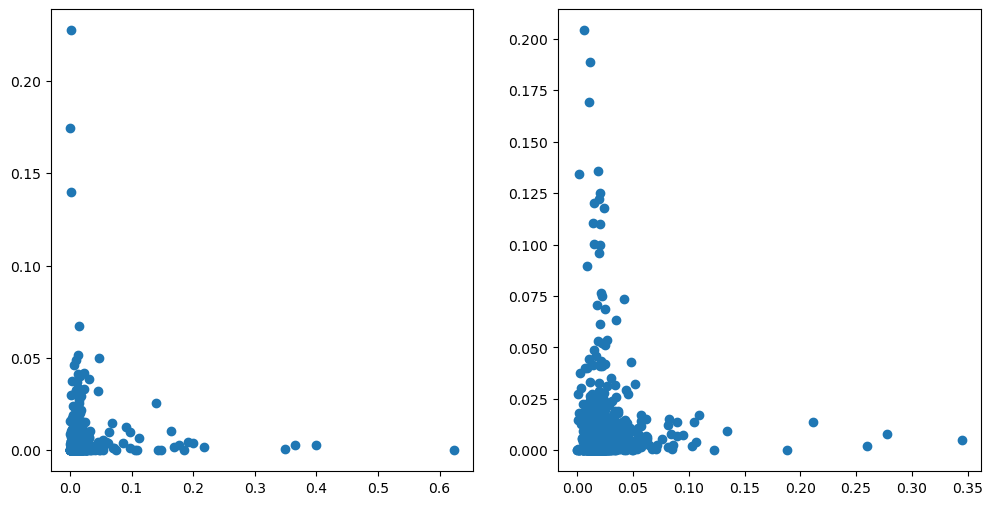

In [10]:
MLD_samples_18Sv4 = env_features_18Sv4.loc[ env_features_18Sv4["Bottle_Depth"] <= env_features_18Sv4["MLD_Sigma"] ].index
MLD_samples_18Sv9 = env_features_18Sv9.loc[ env_features_18Sv9["Bottle_Depth"] <= env_features_18Sv9["MLD_Sigma"] ].index

fig,ax = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(12)
ax[0].scatter(CM_asv_freqs_18Sv4.loc[MLD_samples_18Sv4], diatom_asv_freqs_18Sv4.loc[MLD_samples_18Sv4])
ax[1].scatter(CM_asv_freqs_18Sv9.loc[MLD_samples_18Sv9], diatom_asv_freqs_18Sv9.loc[MLD_samples_18Sv9])
plt.show()

Deep water (Bottle Depth < MLD_Sigma) samples: 18Sv4 and 18Sv9 datasets show different levels of capture for CMs and diatoms, it's hard to think that both of these outcomes represent the same microbial communities. Possible biases with primers used, capture methods, or taxonomies?

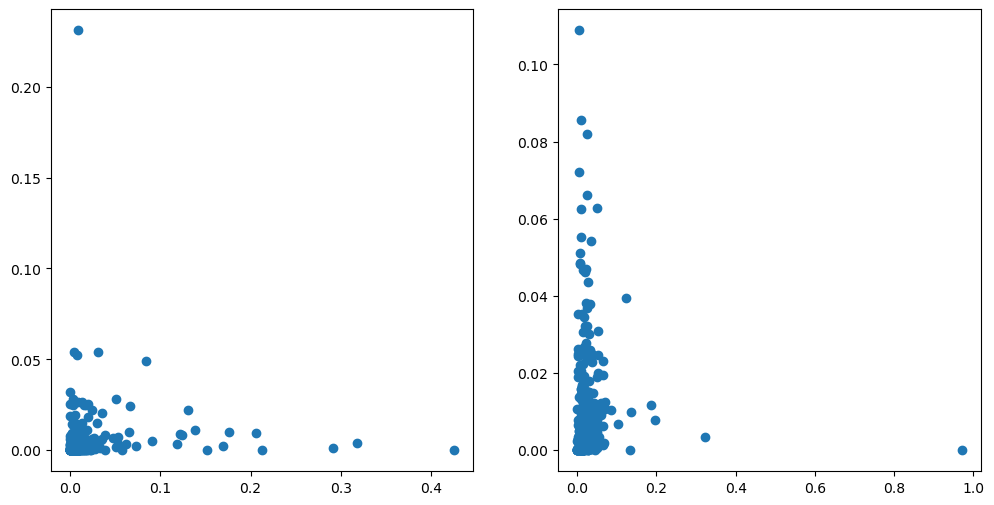

In [11]:
fig,ax = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(12)
ax[0].scatter(CM_asv_freqs_18Sv4.drop(MLD_samples_18Sv4), diatom_asv_freqs_18Sv4.drop(MLD_samples_18Sv4))
ax[1].scatter(CM_asv_freqs_18Sv9.drop(MLD_samples_18Sv9), diatom_asv_freqs_18Sv9.drop(MLD_samples_18Sv9))
plt.show()

In [12]:
def outliers(series):
    q3 = np.quantile(series, 0.75)
    IQR = q3 - np.quantile(series, 0.25)
    return pd.Series(series.loc[ series > (q3 + (1.5 * IQR)) ].index)

#samples in which there is an outlier amount of diatoms and/or CMs.
#includes only the shallow water samples!
all_MLD_outliers_18Sv4 = pd.concat([outliers(CM_asv_freqs_18Sv4.loc[MLD_samples_18Sv4]),
                                    outliers(diatom_asv_freqs_18Sv4.loc[MLD_samples_18Sv4])],
                                    ignore_index=True).drop_duplicates()
all_MLD_outliers_18Sv9 = pd.concat([outliers(CM_asv_freqs_18Sv9.loc[MLD_samples_18Sv9]),
                                    outliers(diatom_asv_freqs_18Sv9.loc[MLD_samples_18Sv9])],
                                    ignore_index=True).drop_duplicates()

In [13]:
#includes only samples above MLD
CM_dom_MLD_outliers_18Sv4 = all_MLD_outliers_18Sv4[
    all_MLD_outliers_18Sv4.apply(lambda x: CM_asv_freqs_18Sv4[x] > diatom_asv_freqs_18Sv4[x])
]
diatom_dom_MLD_outliers_18Sv4 = all_MLD_outliers_18Sv4[
    all_MLD_outliers_18Sv4.apply(lambda x: CM_asv_freqs_18Sv4[x] <= diatom_asv_freqs_18Sv4[x])
]

CM_dom_MLD_outliers_18Sv9 = all_MLD_outliers_18Sv9[
    all_MLD_outliers_18Sv9.apply(lambda x: CM_asv_freqs_18Sv9[x] > diatom_asv_freqs_18Sv9[x])
]
diatom_dom_MLD_outliers_18Sv9 = all_MLD_outliers_18Sv9[
    all_MLD_outliers_18Sv9.apply(lambda x: CM_asv_freqs_18Sv9[x] <= diatom_asv_freqs_18Sv9[x])
]

In [14]:
CM_dom_MLD_outliers_18Sv4.size, diatom_dom_MLD_outliers_18Sv4.size, all_MLD_outliers_18Sv4.size

(69, 49, 118)

In [15]:
CM_dom_MLD_outliers_18Sv9.size, diatom_dom_MLD_outliers_18Sv9.size, all_MLD_outliers_18Sv9.size

(71, 70, 141)

Distributions of X-dominated outlier samples along environmental gradients: already found the seasonal link, can continue from there. Refer to notebook 02.

In [16]:
env_features_18Sv4["MixedLayer_Outlier"] = "not"
env_features_18Sv4.loc[CM_dom_MLD_outliers_18Sv4, "MixedLayer_Outlier"] = "CM_dominated"
env_features_18Sv4.loc[diatom_dom_MLD_outliers_18Sv4, "MixedLayer_Outlier"] = "diatom_dominated"
env_features_18Sv4.loc[MLD_samples_18Sv4].to_csv("02_out_env_features_18Sv4.tsv", sep = "\t")

env_features_18Sv9["MixedLayer_Outlier"] = "not"
env_features_18Sv9.loc[CM_dom_MLD_outliers_18Sv9, "MixedLayer_Outlier"] = "CM_dominated"
env_features_18Sv9.loc[diatom_dom_MLD_outliers_18Sv9, "MixedLayer_Outlier"] = "diatom_dominated"
env_features_18Sv9.loc[MLD_samples_18Sv9].to_csv("02_out_env_features_18Sv9.tsv", sep = "\t")

### Filtering rows (samples): Removing NA values/dropping samples that have them. 

Seems that FlashWeave can't handle them since missing values are turned into SubString{String} "" and mess up the preprocessing.

"Treatment of missing values
FlashWeave currently does not support missing data, please remove all samples with missing entries (both in OTU and meta data tables) prior to running FlashWeave. "

In [17]:
env_features_18Sv4.loc[MLD_samples_18Sv4].iloc[510:521,5]

X201911_080.0_100.0_12    18.979000
X201911_081.8_046.9_10    16.910000
X201911_083.3_051.0_10    16.730000
X201911_083.3_090.0_9     16.455999
X201911_086.7_035.0_10          NaN
X201911_086.7_060.0_8     16.896999
X201911_086.7_100.0_14    18.934999
X201911_090.0_037.0_10    18.455000
X201911_090.0_045.0_10    18.558001
X201911_090.0_053.0_10    17.969999
X201911_090.0_070.0_10    16.983000
Name: T_degC, dtype: float64

In [18]:
env_features_18Sv4.isna().apply(sum, axis = 0).sort_values(ascending=False)

RecInd                152
NH3ug                  94
Cast_Type              79
PO4ug                  37
SiO3ug                 37
NO3ug                  37
Cardinal_Sta           24
ChlorA                 12
Phaeop                 12
O2ml_L                  8
T_degC                  6
Salnty                  4
STheta                  4
Bottle_Depth            4
Lon_Dec                 4
Lat_Dec                 4
MLD_Sigma               4
year                    4
month                   4
season                  4
Mins_since_0000         4
MixedLayer_Outlier      0
dtype: int64

In [19]:
#drop chlorA and Phaeop[hycin], unhelpful correlations between metavariables
#drop RecInd, too many nulls; drop NH3ug, same reasons
#keep Cast_Type, etc. to find "hidden" effects on species counts
useful_features = env_features_18Sv4.columns.drop(["ChlorA", "Phaeop", "RecInd", "NH3ug"])
useful_features

Index(['Cast_Type', 'Cardinal_Sta', 'Lat_Dec', 'Lon_Dec', 'Bottle_Depth',
       'T_degC', 'Salnty', 'STheta', 'O2ml_L', 'PO4ug', 'SiO3ug', 'NO3ug',
       'MLD_Sigma', 'year', 'month', 'season', 'Mins_since_0000',
       'MixedLayer_Outlier'],
      dtype='object')

In [20]:
#Both of these variables are read as strings, so might as well add "unknown" as a possible string-- using missing values as
#another factor value
env_features_18Sv4["Cast_Type"] = env_features_18Sv4["Cast_Type"].replace(np.nan, "unknown")
env_features_18Sv9["Cast_Type"] = env_features_18Sv9["Cast_Type"].replace(np.nan, "unknown")

env_features_18Sv4["Cardinal_Sta"] = env_features_18Sv4["Cardinal_Sta"].replace(np.nan, "unknown")
env_features_18Sv9["Cardinal_Sta"] = env_features_18Sv9["Cardinal_Sta"].replace(np.nan, "unknown")

In [21]:
env_features_18Sv4[useful_features].isna().apply(sum, axis = 0).sort_values(ascending=False)

PO4ug                 37
SiO3ug                37
NO3ug                 37
O2ml_L                 8
T_degC                 6
season                 4
Lat_Dec                4
Lon_Dec                4
Bottle_Depth           4
Salnty                 4
STheta                 4
Mins_since_0000        4
MLD_Sigma              4
year                   4
month                  4
Cast_Type              0
Cardinal_Sta           0
MixedLayer_Outlier     0
dtype: int64

In [22]:
env_features_18Sv4.shape, env_features_18Sv9.shape

((1144, 22), (1484, 22))

In [23]:
#these series are derived from the "asv_freqs" tables which already have Spike sequence counts and all-zero rows removed.
MLD_samples_18Sv4.size, MLD_samples_18Sv9.size

(623, 790)

In [24]:
env_features_18Sv4.dropna().shape, env_features_18Sv4.loc[MLD_samples_18Sv4].dropna().shape

((957, 22), (509, 22))

In [25]:
env_features_18Sv9.dropna().shape, env_features_18Sv9.loc[MLD_samples_18Sv9].dropna().shape 

((1281, 22), (673, 22))

In [26]:
#might as well drop the samples now.
env_features_18Sv4 = env_features_18Sv4.dropna()
env_features_18Sv9 = env_features_18Sv9.dropna()

MLD_samples_18Sv4 = MLD_samples_18Sv4.intersection(env_features_18Sv4.index)
MLD_samples_18Sv9 = MLD_samples_18Sv9.intersection(env_features_18Sv9.index)

raw_asv_counts_18Sv4 = raw_asv_counts_18Sv4[env_features_18Sv4.index]
raw_asv_counts_18Sv9 = raw_asv_counts_18Sv9[env_features_18Sv9.index]

In [27]:
env_features_18Sv4.shape, MLD_samples_18Sv4.shape, raw_asv_counts_18Sv4.shape

((957, 22), (509,), (34496, 957))

In [28]:
env_features_18Sv9.shape, MLD_samples_18Sv9.shape, raw_asv_counts_18Sv9.shape

((1281, 22), (673,), (50407, 1281))

### Filtering columns (ASVs).

third-quartile filter described in Chaffron: for each sample find Q3. each ASV must be above sample Q3 for at least five samples.

ASV consolidation by species: add together any ASVs that have the same species name?

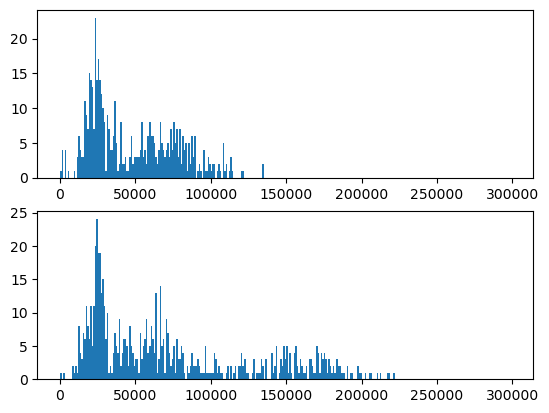

In [29]:
#total raw read counts for MLD samples only.
fig, ax = plt.subplots(2)
ax[0].hist(raw_asv_counts_18Sv4[MLD_samples_18Sv4].apply(sum), bins = range(0, 300000, 1000))
ax[1].hist(raw_asv_counts_18Sv9[MLD_samples_18Sv9].apply(sum), bins = range(0, 300000, 1000))
plt.show()

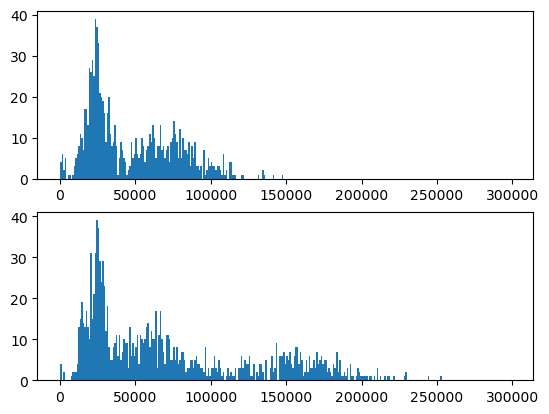

In [30]:
#total raw counts for all samples: histogram
fig, ax = plt.subplots(2)
ax[0].hist(raw_asv_counts_18Sv4.apply(sum), bins = range(0, 300000, 1000))
ax[1].hist(raw_asv_counts_18Sv9.apply(sum), bins = range(0, 300000, 1000))
plt.show()

In [31]:
def consolidate_asvs(frame_row, asv_counts, asv_names):
    species_name = frame_row.name
    #Per sample sums of all ASV counts for ASVs identified as this species.
    #try:
    counts = asv_counts.loc[asv_names == species_name]
    #except ValueError:
    #    print(species_name)
    #    quit(1)
    count_sum = counts.apply(sum, axis = 0).rename(species_name)
    #print(species_name)
    #assert((count_sum.index == asv_counts.columns).all())
    return count_sum

In [32]:
#ASV consolidation: for each ASV, indicate whether corresponding taxon has a species name or not.
has_species_name_18Sv4 = asv_taxo_mft_18Sv4["Taxon"].str.strip(";.").str.split(";").apply(lambda x: len(x) > 8)
no_species_name_18Sv4 = has_species_name_18Sv4.apply(lambda x: not x)

#for those species which have species names, can add together ASV frequencies according to species name
unique_species_names_18Sv4 = asv_taxo_mft_18Sv4.loc[has_species_name_18Sv4, "most_specific_name"].unique()

#new dataframe: rows are samples, columns are sequences or groups of sequences
consolidated_counts_18Sv4 = pd.DataFrame(
    np.zeros((raw_asv_counts_18Sv4.columns.size, unique_species_names_18Sv4.size)), 
    columns = unique_species_names_18Sv4,
    index = raw_asv_counts_18Sv4.columns
).apply(
    consolidate_asvs, 
    axis = 0, #apply function row by row: rows contain species names
    #kwargs
    asv_counts=raw_asv_counts_18Sv4, 
    asv_names=asv_taxo_mft_18Sv4["most_specific_name"]
).join(
    #index to index join
    raw_asv_counts_18Sv4[no_species_name_18Sv4].transpose()
)

In [33]:
#ASV consolidation: for each ASV, indicate whether corresponding taxon has a species name or not.
has_species_name_18Sv9 = asv_taxo_mft_18Sv9["Taxon"].str.strip(";.").str.split(";").apply(lambda x: len(x) > 8)
no_species_name_18Sv9 = has_species_name_18Sv9.apply(lambda x: not x)

#for those species which have species names, can add together ASV frequencies according to species name
unique_species_names_18Sv9 = asv_taxo_mft_18Sv9.loc[has_species_name_18Sv9, "most_specific_name"].unique()

#new dataframe: rows are samples, columns are sequences or groups of sequences
consolidated_counts_18Sv9 = pd.DataFrame(
    np.zeros((raw_asv_counts_18Sv9.columns.size, unique_species_names_18Sv9.size)), 
    columns = unique_species_names_18Sv9,
    index = raw_asv_counts_18Sv9.columns
).apply(
    consolidate_asvs, 
    axis = 0, #apply function row by row: rows contain species names
    #kwargs
    asv_counts=raw_asv_counts_18Sv9, 
    asv_names=asv_taxo_mft_18Sv9["most_specific_name"]
).join(
    #index to index join
    raw_asv_counts_18Sv9[no_species_name_18Sv9].transpose()
)

In [34]:
#no join errors: not even a single cell is false
consolidated_counts_18Sv4.isna().any().any()

False

In [35]:
#no join errors
consolidated_counts_18Sv9.isna().any().any()

False

In [36]:
consolidated_counts_18Sv4.shape

(957, 16745)

How effective would a q3 filter be -> What is the distribution of per-sample Q3s? Turns out it's all 0, for all of them, even after species consolidation!

Would be more effective probably to just outright say "this species/ASV has to have nonzero counts in 10 samples, or 20".

((array([  0.,   0.,   0.,   0.,   0., 957.,   0.,   0.,   0.,   0.]),
  array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
  <BarContainer object of 10 artists>),
 (array([   0.,    0.,    0.,    0.,    0., 1281.,    0.,    0.,    0.,
            0.]),
  array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
  <BarContainer object of 10 artists>))

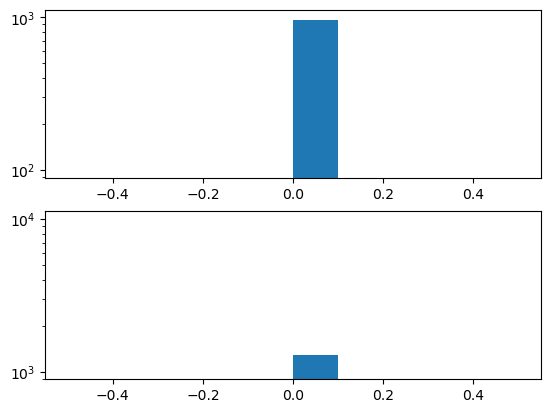

In [37]:
per_sample_q3_18Sv4 = consolidated_counts_18Sv4.apply(lambda row: np.quantile(row, 0.75), axis = 1)
per_sample_q3_18Sv9 = consolidated_counts_18Sv9.apply(lambda row: np.quantile(row, 0.75), axis = 1)
fig, ax = plt.subplots(2,1)
ax[0].hist(per_sample_q3_18Sv4, log = True),\
ax[1].hist(per_sample_q3_18Sv9, log = True)

In [38]:
def q3_filter_mask(frame):
    #Iterates over samples and generates Q3 for each.
    per_sample_q3 = frame.apply(lambda row: np.quantile(row, 0.75), axis = 1) #apply to each row
    #print(per_sample_q3.shape)
    
    #Iterates over "species" and checks sample abundance > Q3. if sum(...) < 5, discard this "species"
    #return row_mask
    return frame.apply(lambda col: sum( col > per_sample_q3 ) >= 5)
    
filtered_counts_18Sv4 = consolidated_counts_18Sv4.loc[:, q3_filter_mask(consolidated_counts_18Sv4)]
filtered_counts_18Sv9 = consolidated_counts_18Sv9.loc[:, q3_filter_mask(consolidated_counts_18Sv9)]

In [39]:
filtered_counts_18Sv4.shape, filtered_counts_18Sv9.shape

((957, 3092), (1281, 8475))

Still a lot of zeroes, could lead to spurious correlations. Can try this again with the no_species ASVs removed: this allows a much higher proportion of nonzero values.

**As an intermediate solution, can also make the q3 filter more stringent.** But the maximum expected "nonzero cell percentage" won't exceed 18% in 18Sv4, 23% in 18Sv9.

In [40]:
sum(filtered_counts_18Sv4.values.flatten() > 0)/filtered_counts_18Sv4.size

0.078076567972629

In [41]:
sum(filtered_counts_18Sv9.values.flatten() > 0)/filtered_counts_18Sv9.size

0.06073499915948777

In [42]:
sum(filtered_counts_18Sv4[filtered_counts_18Sv4.columns.drop(asv_freqs_18Sv4.index, errors="ignore")].values.flatten() > 0)\
/filtered_counts_18Sv4[filtered_counts_18Sv4.columns.drop(asv_freqs_18Sv4.index, errors="ignore")].size

0.18069072007134823

In [43]:
sum(filtered_counts_18Sv9[filtered_counts_18Sv9.columns.drop(asv_freqs_18Sv9.index, errors="ignore")].values.flatten() > 0)\
/filtered_counts_18Sv9[filtered_counts_18Sv9.columns.drop(asv_freqs_18Sv9.index, errors="ignore")].size

0.23797362039269004

#mean percentile for a given species within each sample...
#would need access to each row to calculate rank, and access to each col to calculate mean rank. every single calculation
#would make use of the entire matrix.
#instead, just using mean proportion.

In [44]:
#can make proportions with per-column or per-row totals: here, samples are rows.
from helper_functions import proportional_frequencies

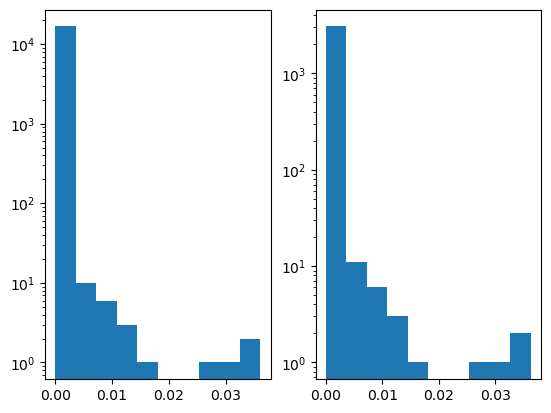

In [45]:
fig, ax = plt.subplots(1,2)
ax[0].hist(consolidated_counts_18Sv4.apply(proportional_frequencies, axis = 1).apply(np.median, axis = 0), log = True)
ax[1].hist(filtered_counts_18Sv4.apply(proportional_frequencies, axis = 1).apply(np.median, axis = 0), log = True)
plt.show()

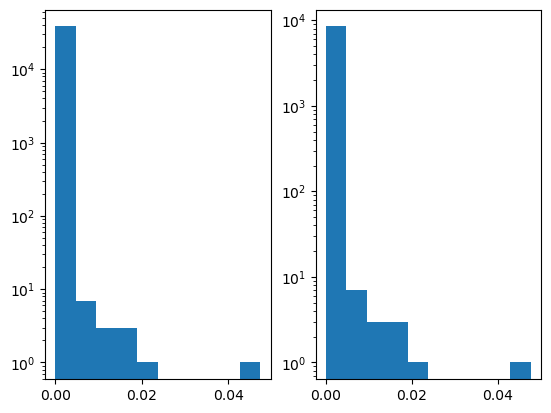

In [46]:
fig, ax = plt.subplots(1,2)
ax[0].hist(consolidated_counts_18Sv9.apply(proportional_frequencies, axis = 1).apply(np.median, axis = 0), log = True)
ax[1].hist(filtered_counts_18Sv9.apply(proportional_frequencies, axis = 1).apply(np.median, axis = 0), log = True)
plt.show()

### Preparing tables for Flashweave.

"NOTE: OTU table and metadata table must be aligned such that each row corresponds to the same sample in both files (i.e. sample 1 data is found in row 1 in both files, etc.)."

leave sample ID in, it has only been removed from the "tiny" examples, is present in the "small".

"Meta variables containing string factors with more than two categories are automatically one-hot encoded by FlashWeave prior to network inference to increase the reliability and interpretability of statistical tests (the user will be notified if this happens)."

See the "attack" notebook from michael for how graph output becomes readable, esp. in python. (it becomes so by exporting a .gml graph from flashweave and importing it into python environment with networkx)

In [47]:
categorical_env_features = env_features_18Sv4.select_dtypes(exclude=[float]).columns
numerical_env_features = env_features_18Sv4.select_dtypes(include=[float]).columns
categorical_env_features.size, numerical_env_features.size, env_features_18Sv4.columns.size

(4, 18, 22)

(14, 14)

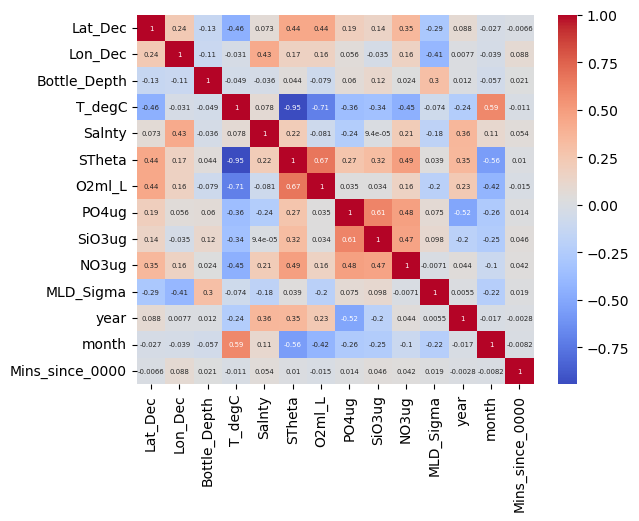

In [48]:
import seaborn as sns
#kendall, spearman both show similar looking graphs
feature_correlations_18Sv4 = env_features_18Sv4.loc[
    MLD_samples_18Sv4, 
    numerical_env_features.intersection(useful_features)
].corr(method="spearman")
#with sns.set_theme(rc={'figure.figsize':(15,12), 'font.size':10}): #local context
sns.heatmap(feature_correlations_18Sv4, cmap='coolwarm', annot=True, annot_kws={"size":5})
feature_correlations_18Sv4.shape

In [49]:
MLD_samples_18Sv4.size, MLD_samples_18Sv9.size

(509, 673)

In [50]:
filtered_counts_18Sv4.shape, filtered_counts_18Sv4.loc[MLD_samples_18Sv4].shape

((957, 3092), (509, 3092))

In [51]:
#should now be safe for Flashweave.
env_features_18Sv4.isna().any().any(), env_features_18Sv9.isna().any().any()

(False, False)

Number of output tables:
- leave out non-MLD samples vs leave them in.
- 18Sv4 vs v9.
- pseudocounts vs no pseudocounts.
8 tables total? and that's just species counts, but metadata shouldn't change except for the MLD-or-not one.

In [52]:
filtered_counts_18Sv4_pcounts = filtered_counts_18Sv4 + 1
filtered_counts_18Sv9_pcounts = filtered_counts_18Sv9 + 1

In [53]:
#delete/comment out based on what flasheave rejects
filtered_counts_18Sv4.to_csv("03_counts_18Sv4_alldepths_nopcounts.tsv", sep = "\t", index=True)
filtered_counts_18Sv4.loc[MLD_samples_18Sv4].to_csv("03_counts_18Sv4_MLD_nopcounts.tsv", sep = "\t", index=True)
filtered_counts_18Sv4_pcounts.to_csv("03_counts_18Sv4_alldepths_pcounts.tsv", sep = "\t", index=True)
filtered_counts_18Sv4_pcounts.loc[MLD_samples_18Sv4].to_csv("03_counts_18Sv4_MLD_pcounts.tsv", sep = "\t", index=True)

filtered_counts_18Sv9.to_csv("03_counts_18Sv9_alldepths_nopcounts.tsv", sep = "\t", index=True)
filtered_counts_18Sv9.loc[MLD_samples_18Sv9].to_csv("03_counts_18Sv9_MLD_nopcounts.tsv", sep = "\t", index=True)
filtered_counts_18Sv9_pcounts.to_csv("03_counts_18Sv9_alldepths_pcounts.tsv", sep = "\t", index=True)
filtered_counts_18Sv9_pcounts.loc[MLD_samples_18Sv9].to_csv("03_counts_18Sv9_MLD_pcounts.tsv", sep = "\t", index=True)

In [54]:
#metavariable tables: alldepths vs MLD, for 18Sv4 and v9.
env_features_18Sv4[useful_features].to_csv("03_mvars_18Sv4_alldepths.tsv", sep = "\t", index=True)
env_features_18Sv4.loc[MLD_samples_18Sv4, useful_features].to_csv("03_mvars_18Sv4_MLD.tsv", sep = "\t", index=True)

env_features_18Sv9[useful_features].to_csv("03_mvars_18Sv9_alldepths.tsv", sep = "\t", index=True)
env_features_18Sv9.loc[MLD_samples_18Sv9, useful_features].to_csv("03_mvars_18Sv9_MLD.tsv", sep = "\t", index=True)

### 16S Tables? 

Flashweave can normalize them independently. pretty sure they have to have the same row number and order as the other tables (18S and metadata).

In [85]:
import re
#a = re.compile(r"""\d +  # the integral part
#                   \.    # the decimal point
#                   \d *  # some fractional digits""", re.X)

In [57]:
raw_asv_counts_16S = pd.read_csv("input_data_files/NCOG_21_16S_redo2_asv_count_tax.tsv", sep = "\t", index_col=0)
asv_taxonomies_16S = raw_asv_counts_16S[["silva_Taxon","silva_Confidence"]]

In [75]:
raw_asv_counts_16S.shape

(28909, 1071)

In [113]:
#exclude eukaryota and mitochondrion genes
asvs_to_exclude_16S = asv_taxonomies_16S["silva_Taxon"].str.contains("Eukaryota") |\
                        asv_taxonomies_16S["silva_Taxon"].str.contains("Mitochondria") |\
                        asv_taxonomies_16S["silva_Taxon"].str.contains("Chloroplast")
asvs_to_include_16S = asvs_to_exclude_16S.apply(lambda x: not x)
sum(asvs_to_exclude_16S), sum(asvs_to_include_16S)

(7155, 21754)

In [91]:
tag_16S = re.compile(r"_16S.*")
raw_asv_counts_16S.columns = raw_asv_counts_16S.columns.str.replace(tag_16S, "")

In [104]:
shared_samples_16S_18Sv4 = raw_asv_counts_16S.columns.intersection(filtered_counts_18Sv4.index)
shared_samples_16S_18Sv9 = raw_asv_counts_16S.columns.intersection(filtered_counts_18Sv9.index)

In [105]:
#the only sample to be in 16S and 18Sv9 but not 18Sv4.
raw_asv_counts_16S.columns.drop( shared_samples_16S_18Sv9 ).difference(
raw_asv_counts_16S.columns.drop( shared_samples_16S_18Sv4 )
)

Index(['X201504_083.3_090.0_72'], dtype='object')

In [142]:
#consolidating/filtering 16S? seems necessary since FlashWeave is running out of memory.
species_name = re.compile(r"s")
sum(asv_taxonomies_16S["silva_Taxon"].str.match(r'd'))

28593

In [151]:
#consolidating/filtering 16S? seems necessary since FlashWeave is running out of memory.
#can do this after 18S.
with pd.option_context("display.max_colwidth", None):
    display(asv_taxonomies_16S.loc[asv_taxonomies_16S["silva_Taxon"].str.match(r'.*s__.*'), "silva_Taxon"].loc[asvs_to_include_16S])

Feature.ID
0007750f83d6991ae589d472230b1d11                                                                 d__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Cryomorphaceae; g__NS10_marine_group; s__uncultured_Bacteroidetes/Chlorobi
0014190ab4bbee9c985ea1f7fc5e6116    d__Bacteria; p__Marinimicrobia_(SAR406_clade); c__Marinimicrobia_(SAR406_clade); o__Marinimicrobia_(SAR406_clade); f__Marinimicrobia_(SAR406_clade); g__Marinimicrobia_(SAR406_clade); s__unidentified_marine
001d7fe59fdb2c1a4747c4feb9a8f8ef                                                                       d__Bacteria; p__Bdellovibrionota; c__Bdellovibrionia; o__Bacteriovoracales; f__Bacteriovoracaceae; g__Peredibacter; s__uncultured_organism
0021134a7998b5200704acd47b82c7b7                                                                                                                              d__Bacteria; p__WPS-2; c__WPS-2; o__WPS-2; f__WPS-2; g__WPS-2; s__marine_metagenome
002c14075180e4484913e

In [124]:
asv_counts_16S_18Sv4 = raw_asv_counts_16S.loc[asvs_to_include_16S, shared_samples_16S_18Sv4].transpose()
asv_counts_16S_18Sv4.shape

(800, 21754)

In [116]:
asv_counts_16S_18Sv9 = raw_asv_counts_16S.loc[asvs_to_include_16S, shared_samples_16S_18Sv9].transpose()
asv_counts_16S_18Sv9.shape

(799, 21754)

In [125]:
MLD_samples_16S_18Sv4 = asv_counts_16S_18Sv4.index.intersection(MLD_samples_18Sv4)
MLD_samples_16S_18Sv9 = asv_counts_16S_18Sv9.index.intersection(MLD_samples_18Sv9)

In [126]:
MLD_samples_16S_18Sv4.size, MLD_samples_16S_18Sv9.size

(430, 430)

In [128]:
#cannot save file in a nonexistent directory
asv_counts_16S_18Sv4.to_csv(
    "counts_mvars_16S_and_18S/asv_counts_16S_18Sv4_alldepths.tsv", sep = "\t", index = True)
filtered_counts_18Sv4.loc[shared_samples_16S_18Sv4].to_csv(
    "counts_mvars_16S_and_18S/asv_counts_18Sv4_alldepths.tsv", sep = "\t", index=True)
asv_counts_16S_18Sv9.to_csv(
    "counts_mvars_16S_and_18S/asv_counts_16S_18Sv9_alldepths.tsv", sep = "\t", index = True)
filtered_counts_18Sv9.loc[shared_samples_16S_18Sv9].to_csv(
    "counts_mvars_16S_and_18S/asv_counts_18Sv9_alldepths.tsv", sep = "\t", index=True)

#MLD samples only
asv_counts_16S_18Sv4.loc[MLD_samples_16S_18Sv4].to_csv(
    "counts_mvars_16S_and_18S/asv_counts_16S_18Sv4_MLD.tsv", sep = "\t", index = True)
filtered_counts_18Sv4.loc[MLD_samples_16S_18Sv4].to_csv(
    "counts_mvars_16S_and_18S/asv_counts_18Sv4_MLD.tsv", sep = "\t", index=True)
asv_counts_16S_18Sv9.loc[MLD_samples_16S_18Sv9].to_csv(
    "counts_mvars_16S_and_18S/asv_counts_16S_18Sv9_MLD.tsv", sep = "\t", index = True)
filtered_counts_18Sv9.loc[MLD_samples_16S_18Sv9].to_csv(
    "counts_mvars_16S_and_18S/asv_counts_18Sv9_MLD.tsv", sep = "\t", index=True)

In [129]:
#metavariable tables: alldepths vs MLD, for 18Sv4 and v9.
env_features_18Sv4.loc[shared_samples_16S_18Sv4, useful_features].to_csv(
    "counts_mvars_16S_and_18S/mvars_18Sv4_alldepths.tsv", sep = "\t", index=True)
env_features_18Sv4.loc[MLD_samples_16S_18Sv4, useful_features].to_csv(
    "counts_mvars_16S_and_18S/mvars_18Sv4_MLD.tsv", sep = "\t", index=True)

env_features_18Sv9.loc[shared_samples_16S_18Sv9, useful_features].to_csv(
    "counts_mvars_16S_and_18S/mvars_18Sv9_alldepths.tsv", sep = "\t", index=True)
env_features_18Sv9.loc[MLD_samples_16S_18Sv9, useful_features].to_csv(
    "counts_mvars_16S_and_18S/mvars_18Sv9_MLD.tsv", sep = "\t", index=True)

In [ ]:
assert(False)

Final set of predictors: join MLD_select_numeric_features and onehots for each categorical variable.
(don't expect cardinal and cast type to be basis of any splits so leave them out?)

570 obs for 18Sv4, 734 for 18Sv9. could do a 9:1 train test split. 8:2 maybe.

In [ ]:
#join right frame onto left frame using left frame index
X_18Sv4 = MLD_select_numeric_features_18Sv4.join(season_onehot_18Sv4, how="left")
X_18Sv9 = MLD_select_numeric_features_18Sv9.join(season_onehot_18Sv9, how="left")
X_18Sv4.shape, X_18Sv9.shape

Final responses: prune MLD_dino_CM_diatom_difference_18Sv4 with index of X_18Sv4.

In [ ]:
#y_18Sv4 = MLD_dino_CM_diatom_difference_18Sv4.loc[X_18Sv4.index]
#y_18Sv9 = MLD_dino_CM_diatom_difference_18Sv9.loc[X_18Sv9.index]

y_18Sv4 = CM_asv_freqs_18Sv4[X_18Sv4.index]
y_18Sv9 = CM_asv_freqs_18Sv9[X_18Sv9.index]

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].hist(y_18Sv4, bins = np.arange(0, 1, 1e-2), orientation = "horizontal", log = False)
ax[1].hist(y_18Sv9, bins = np.arange(0, 1, 1e-2), orientation = "horizontal", log = False)
plt.show()

### Bagging Model: Predict difference of per sample dino-CM and diatom percentages (MLD_dino_CM_diatom_difference_18Sv4, 9) in mixed layer depth samples with environmental variables.

Can we identify environmental types with different properties? (expect that many environments will look exactly the same, since response value close to 0).

**Train test split**

There's 1 feature dataset and 2 response datasets, we're going to use ~20% of the features to test later
Make a selection vector and use it to make Xtrain, Xtest, y1train, y1test, y2train, y2test?

Problem! Say I make an ensemble model fitted to 80% of either response vector. If we're starting with the premise that v4 and v9 offer very different views... which one is actually correct? is the test set just going to be "every single observation twice, except associated with two different responses each time?" what would accuracy on something like that even mean?

it would be one thing to have 2 models where ASV data are predictors and something biogeochemical is the response (bowman)...

In [ ]:
X_train_18Sv4, X_test_18Sv4, y_train_18Sv4, y_test_18Sv4 = train_test_split(
    X_18Sv4, 
    y_18Sv4,
    test_size = 0.2, 
    random_state = 0
)

X_train_18Sv9, X_test_18Sv9, y_train_18Sv9, y_test_18Sv9 = train_test_split(
    X_18Sv9, 
    y_18Sv9,
    test_size = 0.2, 
    random_state = 0
)

Tuning number of bagging estimators: is it important? Doesn't seem so, but that's probably more the nature of the data (mostly 0s).

Use 20 estimators, see how results turn out.

In [ ]:
model_18Sv4 = BaggingRegressor(
    #estimator=DecisionTreeRegressor(), #see if we get better results by stopping splits earlier
    n_estimators = 20,
    random_state=0
).fit(X_train_18Sv9, y_train_18Sv9)

residuals = (model_18Sv4.predict(X_test_18Sv4) - y_test_18Sv4)
fig, ax = plt.subplots()
ax.hist(residuals, bins = np.arange(-.3, .3, 1e-2))
plt.show()

np.mean(residuals ** 2)# ** 0.5

In [ ]:
model_env_dino_CM_percent_18Sv9 = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=6), #see if we get better results by stopping splits earlier
    n_estimators = 20,
    random_state=0
).fit(X_train_18Sv9, y_train_18Sv9)

y_pred_18Sv9 = model_env_dino_CM_percent_18Sv4.predict(X_test_18Sv9)
residuals = (y_test_18Sv9 - y_pred_18Sv9)
fig, ax = plt.subplots()
ax.hist(residuals, bins=np.arange(-.3,.3,1e-2))
plt.show()

np.mean(residuals ** 2), np.min(y_pred_18Sv9) #wouldn't expect to go below 0

### Contribution to Reducing SS_residual by Each Variable

In [ ]:
plt.figure(figsize=(15,10))
plot_tree(model_env_dino_CM_percent_18Sv9.estimators_[3],feature_names=X_train_18Sv9.columns, fontsize=8)
plt.show()

In [ ]:
#need a way to access every tree and every split, and count the involvement of each feature
#we can see that every estimator was working from the same set of features
model_env_dino_CM_percent_18Sv9.estimators_features_

In [ ]:
for estimator in model_env_dino_CM_percent_18Sv9.estimators_:
    #binary tree stored as parallel arrays, each array holds info about ith node (internal or leaf)
    tree = estimator.tree_
    print(tree)
    #every -2 represents a leaf node
    #print(tree.feature)
    #mse is the impurity measure for regression
    #print(tree.impurity)

#a good split will decrease the amount of impurity? not necessarily. might split into a large low mse node
#and a small, high mse node. so they have to be weighted?
#MSE decrease = MSE_parent - sum(MSE_children)
#does not need to be calculated when "MSE parent" would be a leaf node.

In [ ]:
total_se_decrease=[0] * X_train_18Sv4.columns.size

for estimator in model_env_dino_CM_percent_18Sv9.estimators_:
    tree = estimator.tree_
    for node_id in range(len(tree.feature)):
        #if this node is a leaf, skip
        feature_id = tree.feature[node_id]
        if feature_id < 0:
            continue
        #if node is not a leaf, find MSE_parent - sum(MSE_children)
        left_child_id = tree.children_left[node_id]
        right_child_id = tree.children_right[node_id]
        SE_parent = tree.impurity[node_id] * tree.n_node_samples[node_id]
        SE_children = (tree.impurity[left_child_id] * tree.n_node_samples[left_child_id]) \
                    + (tree.impurity[right_child_id] * tree.n_node_samples[right_child_id])
        #seems like we can't count on this, a split will choose a bad option even if it's "best"
        #assert(SE_parent >= SE_children)
        #if SE_parent < SE_children:
        #    print(SE_parent, tree.impurity[node_id], tree.n_node_samples[node_id])
        #    print(SE_children, tree.impurity[left_child_id], tree.n_node_samples[left_child_id])
        #    print(tree.impurity[right_child_id], tree.n_node_samples[right_child_id])
        #    print(tree)
        #    assert(False)
        #attribute the MSE decrease to the feature that this node splits on
        total_se_decrease[feature_id] += (SE_parent - SE_children)
        
pd.Series(total_se_decrease, index=X_train_18Sv9.columns).sort_values(ascending=False)